## A Simple Transaction Manager in Python

This notebook implements a simple transaction manager in python. It supports S2PL and MVCC, detects deadlocks, supports the typical isolation levels, and generates pseudo-code.

Copyright Ankur Sharma & Jens Dittrich, [Big Data Analytics Group](https://bigdata.uni-saarland.de/), [CC-BY-SA](https://creativecommons.org/licenses/by-sa/4.0/legalcode)

In [1]:
import random
from tm.transaction_manager import TransactionManager
from tm.enum import IsolationLevel, TransactionStatus

##  Function to generate sample ``accounts`` table

In [2]:
f_names = ['Alan', 'Alexa', 'Maria', 'Chris', 'Lyra', 'Demi', 'Mindy', 'Carol', 'Clark', 'Michael', 'Michelle']
l_names = ['Jones', 'Franklin', 'Melon', 'Jordan', 'Bolt', 'Burns', 'Zest', 'Mueller', 'Hunt', 'Hoellen', 'Kemf']

def get_sample_tx_manager(isolation_level, use_mvcc):
    """ Create a sample transaction manager with sample table
    
    Parameters
    ----------
        isolation_level :IsolationLevel
            The isolation level to be used by the transaction manager. Available options:
                SingleVersion: READ_UNCOMMITTED, READ_COMMITTED, REPEATABLE_READS, SERIALIZABLE
                Multi-Version: SNAPSHOT_ISOLATION, SERIALIZABLE
                
        use_mvcc :bool
            Should the transaction manager use multi-version store underneath?
            
    Returns
    -------
        :TransactionManager with a sample table
    
    """
    tx_manager = TransactionManager(isolation_level, use_mvcc)
    tx_manager.add_table('accounts', ['Firstname', 'Lastname', 'Balance'], [str, str, float])
    
    # insert sample data
    tx = tx_manager.begin_transaction()
    
    for i in range(4):
        rnd_fname = f_names[random.randint(0, 10)]
        rnd_lname = l_names[random.randint(0, 10)]
        tx.insert('accounts', {'Firstname': rnd_fname, 'Lastname': rnd_lname, 'Balance': 100.0})
    tx_manager.commit_transaction(tx)
    # tx_manager.print_tables()
    return tx_manager

## Create sample schedule

In [3]:

# Sample schedule
"""
Guidelines to write the schedule:

    1. The schedule must be a list of string ordered wrt time.
    2. DO NOT use quotes for table_name and column options.
    3. The values dictionary in UPDATE and INSERT must be a valid dictionary. Key names must be enclosed in
       single quotes.
    4. Multi-version implementation only supports SNAPSHOT_ISOLATION and SERIALIZABLE isolation levels.
    5. Single-version implementation does not supports SNAPSHOT_ISOLATION.
    6. Each string in the schedule consists of a transaction name and a statement to execute, separated by a semi-colon.
       
       
Allowed operations:
    1. READ(table_name=sample_table, rowid=0, column=Balance)
        Read the given `Balance` value from the row whose rowid is `0` from sample_table. DO NOT enclose the
        table_name and column in quotes.
            
    2. UPDATE(table_name=sample_table, rowid=0, values={'Balance': 100.0})
        Update the `Balance` to `100.0` in row whose rowid is `0` in the sample_table. The values parameter must
        be a string representation of a valid python dictionary.
        
    3. INSERT(table_name=sample_table, values={'Balance': 100.0, ... })
        Insert the given row in the sample_table. The values parameter must be a string representation of a 
        valid python dictionary.
        
    4. DELETE(table_name=sample_table, rowid=0)
        Delete row whose rowid is `0` from the sample table. DO NOT enclose the table_name in quotes.
        
    5. ASSERT(constraint=())
        Check if the constraint holds. The constraint must be a valid python logical expression. DO NOT enclose
        the constraint in quotes. If the constraint is violated, the transaction is ABORTED.
    
    6. COMMIT()
        Commit the transaction.
    
    7. ABORT()
        Abort the transaction.
"""

schedule = [
    "TX2; BEGIN()",
    "TX2; bal2_0 = READ(table_name=accounts, rowid=0, column=Balance)",
    "TX2; ASSERT(constraint=(bal2_0 >= 100))",
    "TX1; BEGIN()",
    "TX1; bal1_0 = READ(table_name=accounts, rowid=0, column=Balance)",
    "TX2; UPDATE(table_name=accounts, rowid=0, values={'Balance': bal2_0 - 100.0})",
    "TX2; COMMIT()",
    "TX1; ASSERT(constraint=(bal1_0 >= 100))",
    "TX1; bal1_0 = READ(table_name=accounts, rowid=0, column=Balance)",
    "TX1; UPDATE(table_name=accounts, rowid=0, values={'Balance': bal1_0 - 100.0})",
    "TX3; BEGIN()",
    "TX3; bal3_3 = READ(table_name=accounts, rowid=3, column=Balance)",
    "TX3; UPDATE(table_name=accounts, rowid=3, values={'Balance': bal3_3 + 100.0})",
    "TX1; bal1_3 = READ(table_name=accounts, rowid=3, column=Balance)",
    "TX3; ABORT()",
    "TX1; UPDATE(table_name=accounts, rowid=3, values={'Balance': bal1_3 + 100.0})",
    "TX1; COMMIT()"
]

### Create sample TransactionManager

Note: T3 is forcefully aborted so it can never commit.

#### Behaviour under different Isolation Levels

* Lock Based Concurrency Control
    1. **READ_UNCOMMITTED**: This isolation level allows dirty reads. So, even though **T3** aborts, **T1** can read the uncommitted modifications done by **T3**, and can still commit.
    2. **READ_COMMITTED**: Since the read locks are immediately released after reading a tuple in this isolation level, we can observe that **T1** and **T2** can both commit even in the presence of cycle (due to write skew) in the precedence graph.
    3. **REPEATABLE_READS**: In this isolation, one transaction per cycle in the precedence graph must abort. This is why only **T1** or **T2** is able to commit under this isolation level (here **T2**). Phantom reads are allowed in this isolation level. Since we do not allow predicated reads in this implementation, this is same as SERIALIZABLE.
    4. **SERIALIZABLE**: In this isolation, one transaction per cycle in the precedence graph must abort. This is why only **T1** or **T2** is able to commit under this isolation level (here **T2**).
    
    
    
* Multi-version Concurrency Control (Core Lecture)
    1. **SNAPSHOT_ISOLATION**: Under this isolation level, every transaction sees the state as of the time when it started. Write skew is allowed under this isolation level. **T1** and **T2** both commit under this isolation level.
    2. **SERIALIZABLE**: In this isolation, one transaction per cycle in the precedence graph must abort. This is why only **T2** is able to commit under this isolation level.

In [4]:
# Create a sample transaction manager with a sample accounts table with 4 rows and
# balance initialized to 100.0
tx_manager = get_sample_tx_manager(IsolationLevel.SERIALIZABLE, use_mvcc=False)

### Precedence Graph

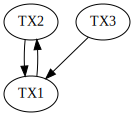

In [5]:
# Draw the precedence graph
tx_manager.generate_precedence_graph(schedule)

### Execute the schedule

In [6]:
# Try to execute the given schedule using the transaction manager
tx_manager.execute_schedule(schedule, dump_exec_code=False)

******************
submitted_schedule
******************
0 	  TX2 	=>  BEGIN()
1 	  TX2 	=>  bal2_0 = READ(table_name=accounts, rowid=0, column=Balance)
2 	  TX2 	=>  ASSERT(constraint=(bal2_0 >= 100))
3 	  TX1 	=>  BEGIN()
4 	  TX1 	=>  bal1_0 = READ(table_name=accounts, rowid=0, column=Balance)
5 	  TX2 	=>  UPDATE(table_name=accounts, rowid=0, values={'Balance': bal2_0 - 100.0})
6 	  TX2 	=>  COMMIT()
7 	  TX1 	=>  ASSERT(constraint=(bal1_0 >= 100))
8 	  TX1 	=>  bal1_0 = READ(table_name=accounts, rowid=0, column=Balance)
9 	  TX1 	=>  UPDATE(table_name=accounts, rowid=0, values={'Balance': bal1_0 - 100.0})
10 	  TX3 	=>  BEGIN()
11 	  TX3 	=>  bal3_3 = READ(table_name=accounts, rowid=3, column=Balance)
12 	  TX3 	=>  UPDATE(table_name=accounts, rowid=3, values={'Balance': bal3_3 + 100.0})
13 	  TX1 	=>  bal1_3 = READ(table_name=accounts, rowid=3, column=Balance)
14 	  TX3 	=>  ABORT()
15 	  TX1 	=>  UPDATE(table_name=accounts, rowid=3, values={'Balance': bal1_3 + 100.0})
16 	  TX1 

# Write Skew Anomaly (Core Lecture)

## Create sample schedule

In [7]:
# Sample schedule
'''
This example contains two transactions TX1 and TX2. They both read a row which is modified
by other transactions. This schedule leads to a cycle in the serialization graph implying 
that both of these transactions cannot commit under full serializability. However, they can
both commit under SNAPSHOT_ISOLATION.
'''

schedule = [
    "TX1; BEGIN()",
    "TX1; bal1_0 = READ(table_name=accounts, rowid=0, column=Balance)",
    "TX1; bal1_3 = READ(table_name=accounts, rowid=3, column=Balance)",
    
    "TX2; BEGIN()",
    "TX2; bal2_3 = READ(table_name=accounts, rowid=3, column=Balance)",
    
    "TX1; ASSERT(constraint=(bal1_0 >= 0))",
    
    "TX2; bal2_0 = READ(table_name=accounts, rowid=0, column=Balance)",
    
    "TX2; ASSERT(constraint=(bal2_3 >= 0))",
    
    "TX1; UPDATE(table_name=accounts, rowid=3, values={'Balance': bal1_3 - 100.0})",
    "TX2; UPDATE(table_name=accounts, rowid=0, values={'Balance': bal2_0 - 100.0})",

    "TX2; COMMIT()",
    "TX1; COMMIT()"
]

### Create sample TransactionManager

In [8]:
# Create a sample transaction manager with a sample accounts table with 4 rows and
# balance initialized to 100.0
tx_manager = get_sample_tx_manager(IsolationLevel.SERIALIZABLE, use_mvcc=True)

### Precedence Graph

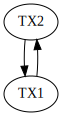

In [9]:
# Draw the precedence graph
tx_manager.generate_precedence_graph(schedule)

### Execute the schedule

In [10]:
# Execute the given schedule using the transaction manager
tx_manager.execute_schedule(schedule, dump_exec_code=False)

******************
submitted_schedule
******************
0 	  TX1 	=>  BEGIN()
1 	  TX1 	=>  bal1_0 = READ(table_name=accounts, rowid=0, column=Balance)
2 	  TX1 	=>  bal1_3 = READ(table_name=accounts, rowid=3, column=Balance)
3 	  TX2 	=>  BEGIN()
4 	  TX2 	=>  bal2_3 = READ(table_name=accounts, rowid=3, column=Balance)
5 	  TX1 	=>  ASSERT(constraint=(bal1_0 >= 0))
6 	  TX2 	=>  bal2_0 = READ(table_name=accounts, rowid=0, column=Balance)
7 	  TX2 	=>  ASSERT(constraint=(bal2_3 >= 0))
8 	  TX1 	=>  UPDATE(table_name=accounts, rowid=3, values={'Balance': bal1_3 - 100.0})
9 	  TX2 	=>  UPDATE(table_name=accounts, rowid=0, values={'Balance': bal2_0 - 100.0})
10 	  TX2 	=>  COMMIT()
11 	  TX1 	=>  COMMIT()

*****************
executed_schedule
*****************
3 	  TX2 	=>  BEGIN()
4 	  TX2 	=>  bal2_3 = READ(table_name=accounts, rowid=3, column=Balance)
6 	  TX2 	=>  bal2_0 = READ(table_name=accounts, rowid=0, column=Balance)
7 	  TX2 	=>  ASSERT(constraint=(bal2_3 >= 0))
9 	  TX2 	=>  U